Ignore SSL error when pulling file from S3

In [719]:
# avoid SSL errors
import ssl

import numpy as np

ssl._create_default_https_context = ssl._create_unverified_context

Read dataset and show it

In [720]:
import pandas as pd

# read csv and remove one emtpy row
df = pd.read_csv("https://npg-ds.s3.amazonaws.com/titanic.csv")[:-1]
df.copy()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3.0,0.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN


The dataset has `1308` rows and the following columns:

* pclass: In which class  (1 = 1st; 2 = 2nd; 3 = 3rd)
* survived: Whether the passenger survived (0 = No; 1 = Yes)
* name: Name of the passenger
* sex: Sex
* age: Age in years
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* ticket: Ticket number
* fare: Passenger fare
* cabin: Cabin number
* embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat: Which boat the passenger got into
* body: Passenger was assigned a corpse number (died)
* home.dest: Home/Destination

Let's see some statistics on the data

In [721]:
df.copy().describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Let's now start checking for some initial statistics about our dataset. For instance we could check for null values per column:

In [722]:
df.isnull().sum()

# available cabin data by pclass
# df.groupby("pclass")["cabin"].apply(lambda x: (x.notna().sum())).reset_index(name="count")

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We can see that `cabin` is missing a lot of values 1014 out of 1308. This means we can't use this column. If we were to fill the missing values with something calculated we would bias the data too much. Also we have other good options representing the same concept (`fare`, `pclass`).

We can also see that we are missing a lot of values for `boat`, that's okay because the missing values means that they didn't make it to the boat. We can replace the missing values with a zero to represent the ones that didn't make it to the boat. Same case for `body`.

Another conclusion we can take is that we are missing quite a few values for age, 263/1308. We will work around this by finding a way to replace the missing values with a value that make sense.

We are also missing quite a few `home.dest` values, but we don't really have use for those.

All in all, let's do the following:

* Remove `cabin`
* Remove `home.dest`
* Replace `null` values in `boat` for a 0, other values for a 1
* Replace `null` values in `body` for a 0, other values for a 1
* Replace missing age values for the mean (later we will try to create a model for predicting the age)

In [723]:
from typing import Any

# remove columns
df = df.drop("home.dest", axis=1)
df = df.drop("cabin", axis=1)

def convert_to_binomial(value: Any) -> int:
    if str(value) == str(np.nan):
        return 0
    return 1

# convert to binomial
df["boat"] = df.boat.apply(convert_to_binomial)
df["body"] = df.body.apply(convert_to_binomial)

# replace with mean
df["age"] = df["age"].fillna(df["age"].mean())
df.copy()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,boat,body
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.000000,0.0,0.0,24160,211.3375,S,1,0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.916700,1.0,2.0,113781,151.5500,S,1,0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.000000,1.0,2.0,113781,151.5500,S,0,0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1.0,2.0,113781,151.5500,S,0,1
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1.0,2.0,113781,151.5500,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.500000,1.0,0.0,2665,14.4542,C,0,1
1305,3.0,0.0,"Zabour, Miss. Thamine",female,29.881135,1.0,0.0,2665,14.4542,C,0,0
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.500000,0.0,0.0,2656,7.2250,C,0,1
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.000000,0.0,0.0,2670,7.2250,C,0,0


Let's now remove a few columns we won't use:

* Name: We don't need the name of the passenger for anything
* Embarked: Were the passenger embarked shouldn't make a difference, they were divided in classes anyway
* Ticket: Related to `fare` and `pclass`

In [724]:
df = df.drop("name", axis=1)
df = df.drop("embarked", axis=1)
df = df.drop("ticket", axis=1)

df.copy()

,pclass,survived,sex,age,sibsp,parch,fare,boat,body
0,1.0,1.0,female,29.000000,0.0,0.0,211.3375,1,0
1,1.0,1.0,male,0.916700,1.0,2.0,151.5500,1,0
2,1.0,0.0,female,2.000000,1.0,2.0,151.5500,0,0
3,1.0,0.0,male,30.000000,1.0,2.0,151.5500,0,1
4,1.0,0.0,female,25.000000,1.0,2.0,151.5500,0,0
...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,female,14.500000,1.0,0.0,14.4542,0,1
1305,3.0,0.0,female,29.881135,1.0,0.0,14.4542,0,0
1306,3.0,0.0,male,26.500000,0.0,0.0,7.2250,0,1
1307,3.0,0.0,male,27.000000,0.0,0.0,7.2250,0,0


By looking at the columns we can see that we have some data we need to encode, `sex` and `pclass`. For encoding we will use one hot

In [725]:
from category_encoders import TargetEncoder

# encode sex
ndf = TargetEncoder().fit_transform(df['sex'], df["survived"])
df["sex"] = ndf

# convert pclass to str and encode
df['pclass'] = df['pclass'].astype(str)
ndf = TargetEncoder().fit_transform(df["pclass"], df["survived"])
df["pclass"] = ndf
df.copy()

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,pclass,survived,sex,age,sibsp,parch,fare,boat,body
0,0.619195,1.0,0.727468,29.000000,0.0,0.0,211.3375,1,0
1,0.619195,1.0,0.190985,0.916700,1.0,2.0,151.5500,1,0
2,0.619195,0.0,0.727468,2.000000,1.0,2.0,151.5500,0,0
3,0.619195,0.0,0.190985,30.000000,1.0,2.0,151.5500,0,1
4,0.619195,0.0,0.727468,25.000000,1.0,2.0,151.5500,0,0
...,...,...,...,...,...,...,...,...,...
1304,0.255289,0.0,0.727468,14.500000,1.0,0.0,14.4542,0,1
1305,0.255289,0.0,0.727468,29.881135,1.0,0.0,14.4542,0,0
1306,0.255289,0.0,0.190985,26.500000,0.0,0.0,7.2250,0,1
1307,0.255289,0.0,0.190985,27.000000,0.0,0.0,7.2250,0,0


Let's try to run the correlation matrix and see how does the values we want to use correlate to each other:

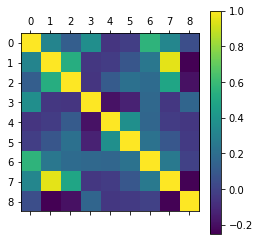

,pclass,survived,sex,age,sibsp,parch,fare,boat,body
pclass,1.000000,0.312533,0.124465,0.367960,-0.059971,-0.018180,0.563100,0.323846,0.048841
survived,0.312533,1.000000,0.528693,-0.050199,-0.027825,0.082660,0.244265,0.948190,-0.250897
sex,0.124465,0.528693,1.000000,-0.057398,0.109609,0.213125,0.185523,0.482086,-0.193214
age,0.367960,-0.050199,-0.057398,1.000000,-0.190747,-0.130872,0.171892,-0.048172,0.157345
sibsp,-0.059971,-0.027825,0.109609,-0.190747,1.000000,0.373587,0.160238,-0.026488,-0.046510
parch,-0.018180,0.082660,0.213125,-0.130872,0.373587,1.000000,0.221539,0.089321,-0.038374
fare,0.563100,0.244265,0.185523,0.171892,0.160238,0.221539,1.000000,0.252717,-0.007752
boat,0.323846,0.948190,0.482086,-0.048172,-0.026488,0.089321,0.252717,1.000000,-0.245246
body,0.048841,-0.250897,-0.193214,0.157345,-0.046510,-0.038374,-0.007752,-0.245246,1.000000


In [726]:
import matplotlib.pyplot as plt

# plot heatmap
plt.matshow(df.corr())
cb = plt.colorbar()
plt.show()

# show numerical values
df.corr()

After taking a look at the chart and the matrix, we can find a correlation between `fare` and `pclass` (around 0.5), between `body` and `survived` and . That tells us that we should remove one of those. The more representative one is `pclass` which tell us in which class the passenger was traveling, so let's keep that one and remove `fare`. We also see high correlations among `survived`, `body` and `boat`, so we will remove those as well.

In [727]:
# drop columns
df = df.drop("fare", axis=1)
df = df.drop("body", axis=1)
df = df.drop("boat", axis=1)
df.copy()

,pclass,survived,sex,age,sibsp,parch
0,0.619195,1.0,0.727468,29.000000,0.0,0.0
1,0.619195,1.0,0.190985,0.916700,1.0,2.0
2,0.619195,0.0,0.727468,2.000000,1.0,2.0
3,0.619195,0.0,0.190985,30.000000,1.0,2.0
4,0.619195,0.0,0.727468,25.000000,1.0,2.0
...,...,...,...,...,...,...
1304,0.255289,0.0,0.727468,14.500000,1.0,0.0
1305,0.255289,0.0,0.727468,29.881135,1.0,0.0
1306,0.255289,0.0,0.190985,26.500000,0.0,0.0
1307,0.255289,0.0,0.190985,27.000000,0.0,0.0


Now we will normalize the numerical data.

In [728]:
# normalize age by mean
df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["sibsp"] = (df["sibsp"] - df["sibsp"].mean()) / df["sibsp"].std()
df["parch"] = (df["parch"] - df["parch"].mean()) / df["parch"].std()

df.copy()

,pclass,survived,sex,age,sibsp,parch
0,0.619195,1.0,0.727468,-6.839408e-02,-0.478904,-0.444829
1,0.619195,1.0,0.190985,-2.248233e+00,0.481104,1.865813
2,0.619195,0.0,0.727468,-2.164147e+00,0.481104,1.865813
3,0.619195,0.0,0.190985,9.226395e-03,0.481104,1.865813
4,0.619195,0.0,0.727468,-3.788760e-01,0.481104,1.865813
...,...,...,...,...,...,...
1304,0.255289,0.0,0.727468,-1.193891e+00,0.481104,-0.444829
1305,0.255289,0.0,0.727468,2.757633e-16,0.481104,-0.444829
1306,0.255289,0.0,0.190985,-2.624453e-01,-0.478904,-0.444829
1307,0.255289,0.0,0.190985,-2.236350e-01,-0.478904,-0.444829


With this data we can now train our model. Initially we will use random forest.

In [729]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# split data for train and test
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

# split into features and labels
training_features = training_data.copy()
training_features = training_features.drop("survived", axis=1)
training_labels = training_data["survived"]

# split into features and labels
testing_features = pd.DataFrame(testing_data.copy())
testing_features = testing_features.drop("survived", axis=1)
testing_labels = pd.DataFrame(testing_data["survived"])

Now, let's try to get a better performance by tuning the RandomForest parameters.

In [730]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
rf_random.fit(training_features, training_labels)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

Now that we know the range of values we can use, we can optimize them using grid search.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [x for x in range(7, 20, 2)],
    'max_features': ["sqrt", "log2"],
    'min_samples_leaf': [x for x in range(1, 5)],
    'min_samples_split': [x for x in range(6, 30, 2)],
    'n_estimators': [x for x in range(1000, 3000, 100)]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(training_features, training_labels)

Fitting 3 folds for each of 16800 candidates, totalling 50400 fits


/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=20

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   2.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.4s
[CV] END bootstrap=True, max_depth=80

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   2.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, max_depth=11

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   2.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   1.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time=   2.4s
[CV] END bootstrap=False, max_depth=

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=8

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   2.3s
[CV] END bootstrap=False, max_depth=3

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJ


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=10, n_estimators=2000; total time=   1.0s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=10, n_estimators=2300; total time=   1.2s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=10, n_estimators=2500; total time=   1.4s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=10, n_estimators=2800; total time=   1.4s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=12, n_estimators=1100; total time=   0.6s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=12, n_estimators=1400; total time=   0.7s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=0, min_samples_split=12, n_estimators=1700; total time=   1.0s
[CV] END bootstrap=True, max_depth=7, ma

In [ ]:
# Instantiate model and fit training data
rf = RandomForestClassifier(**grid_search.best_params_)

# Train the model on training data
rf.fit(training_features, training_labels)

def check_result_match(row) -> int:
    expected = int(row["expected"])
    predicted = int(row["prediction"])
    return int(expected == predicted)

# predict train data
predictions = pd.DataFrame(rf.predict(training_features), columns=["prediction"])
predictions["expected"] = pd.DataFrame(training_labels)["survived"].values
predictions["match"] = predictions.apply(lambda row: check_result_match(row), axis=1)
performance = len(predictions.loc[predictions['match'] == 1]) / len(predictions)
print("Train Performance:", performance)

# predict test data
predictions = pd.DataFrame(rf.predict(testing_features), columns=["prediction"])
predictions["expected"] = testing_labels["survived"].values
predictions["match"] = predictions.apply(lambda row: check_result_match(row), axis=1)
performance = len(predictions.loc[predictions['match'] == 1]) / len(predictions)
print("Test Performance:", performance)